In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import glob
import torch

from PIL import Image

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [2]:
from matplotlib import pyplot
import seaborn as sns

In [3]:
from optimizers import Adan, Lookahead, AGC
from transformers import AutoTokenizer, AutoModel

In [4]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'
PMT_PATH = 'data/environmental/prompt.json'
EMB_PATH = 'data/environmental/clip_text_emb.npz'

MODEL_NAME = 'openai/clip-vit-large-patch14'

WEIGHT_PATH = 'weight/005/environmental/clip_negative'

BATCH_SIZE = -1

LR = 1e-4

# load emb

In [5]:
data = np.load(EMB_PATH, allow_pickle=True)

file_paths = data['file_paths']
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

# load rank data

In [6]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/39552 [00:00<?, ?it/s]

# check conflicts

In [7]:
import networkx

In [8]:
graph = networkx.DiGraph()

In [9]:
for img_1, img_2, sel_id in rank_pairs:
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)

In [10]:
len(graph.nodes), len(graph.edges)

(30892, 39535)

In [11]:
try:
    networkx.find_cycle(graph)
    print('yes')
except:
    print('no')

yes


# check transitive relationship

In [12]:
trans_pairs = list()

for image_1, d in networkx.all_pairs_shortest_path_length(graph):
    
    for image_2, dist in d.items():
        
        if dist <= 1:
            continue
        
        trans_pairs.append((image_1, image_2, dist))
        
trans_pairs = pd.DataFrame(trans_pairs, columns=['image_1', 'image_2', 'dist'])
trans_pairs

,image_1,image_2,dist
0,environmental/0001/000895,environmental/0008/007440,2
1,environmental/0001/000895,environmental/0011/010150,2
2,environmental/0001/000895,environmental/0005/004116,3
3,environmental/0002/001756,environmental/0011/010869,2
4,environmental/0002/001051,environmental/0008/007015,2
...,...,...,...
42624,environmental/0062/061510,environmental/0003/002849,2
42625,environmental/0062/061510,environmental/0049/048422,3
42626,environmental/0062/061276,environmental/0019/018830,2
42627,environmental/0062/061276,environmental/0040/039390,2


# build dataset

In [13]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

rank_pairs

,image_1,image_2,selected_image_index
0,environmental/0002/001719,environmental/0001/000895,0
1,environmental/0003/002102,environmental/0001/000136,0
2,environmental/0002/001756,environmental/0002/001808,1
3,environmental/0001/000456,environmental/0002/001051,0
4,environmental/0002/001608,environmental/0001/000458,0
...,...,...,...
39547,environmental/0006/005516,environmental/0036/035432,0
39548,environmental/0028/027830,environmental/0019/018396,1
39549,environmental/0055/054626,environmental/0023/022451,0
39550,environmental/0006/005168,environmental/0012/011768,1


In [14]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [15]:
train_pairs, val_pairs = train_test_split(ordered_pairs, test_size=0.2, random_state=42)

In [16]:
positive_last_hidden_states = data['positive_last_hidden_states']
positive_attention_masks = data['positive_attention_masks']

negative_last_hidden_states = data['negative_last_hidden_states']
negative_attention_masks = data['negative_attention_masks']

In [17]:
positive_last_hidden_states_with_mask = positive_last_hidden_states * positive_attention_masks[..., None]
negative_last_hidden_states_with_mask = negative_last_hidden_states * negative_attention_masks[..., None]

In [18]:
for i, j in enumerate(positive_attention_masks.argmin(axis=-1)):
    positive_last_hidden_states_with_mask[i, j-1] = 0
        
for i, j in enumerate(negative_attention_masks.argmin(axis=-1)):
    negative_last_hidden_states_with_mask[i, j-1] = 0

In [19]:
positive_last_hidden_states_with_mask[:,0] = 0
negative_last_hidden_states_with_mask[:,0] = 0

## build feature

In [20]:
def build_feature(index_1, index_2, use_positive=True, use_negative=False, use_mask=False):
    
    if use_mask:
        pos_feature = positive_last_hidden_states_with_mask
        neg_feature = negative_last_hidden_states_with_mask
    else:
        pos_feature = positive_last_hidden_states
        neg_feature = negative_last_hidden_states
    
    results = list()
    if use_positive:
        results.append(np.stack([positive_last_hidden_states[index_1], positive_last_hidden_states[index_2]], axis=-1))
    if use_negative:
        results.append(np.stack([negative_last_hidden_states[index_1], negative_last_hidden_states[index_2]], axis=-1))
        
    return np.concatenate(results, axis=0)

In [21]:
use_positive = False
use_negative = True
use_mask = True

train_data = list()
for image_1, image_2 in tqdm(train_pairs.itertuples(index=False, name=None)):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    train_data.append(build_feature(index_1, index_2, use_positive=use_positive, use_negative=use_negative, use_mask=use_mask))
train_data = np.stack(train_data, axis=0)

val_data = list()
for image_1, image_2 in tqdm(val_pairs.itertuples(index=False, name=None)):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    val_data.append(build_feature(index_1, index_2, use_positive=use_positive, use_negative=use_negative, use_mask=use_mask))
val_data = np.stack(val_data, axis=0)

train_data.shape, val_data.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((31641, 77, 768, 2), (7911, 77, 768, 2))

# build model

In [23]:
class Model(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.attention_layer = torch.nn.Conv1d(input_dim, 1, kernel_size=1, bias=True, padding='same')
        
        self.scoring_layer = torch.nn.Conv1d(input_dim, 1, kernel_size=1, bias=False, padding='same')
    
    def get_attention(self, x):

        attn = self.attention_layer(x)
        attn = torch.softmax(attn, dim=-1)
        
        return attn
    
    def forward(self, x, return_all=False):
        
        attn = self.get_attention(x)
        
#         if return_all:
#             scores = self.scoring_layer(x)

#             score = (scores * attn).sum(dim=-1)
#             return attn, scores, score
        
        scores = self.scoring_layer(x)
        
        score = (scores * attn).sum(dim=-1)

        if return_all:
            return attn, scores, score
        
#         x = torch.einsum('bcn,bkn->bck', x, attn)
        
#         score = self.scoring_layer(x)[..., 0]
        
        return score

# train model

In [27]:
train_dataset = torch.tensor(train_data).permute(0, 2, 1, 3).half()
val_dataset = torch.tensor(val_data).permute(0, 2, 1, 3).half()
if BATCH_SIZE > 0:
    train_dataset = train_dataset.pin_memory()
    val_dataset = val_dataset.pin_memory()
else:
    train_dataset = train_dataset.cuda()
    val_dataset = val_dataset.cuda()

In [28]:
model = Model(train_data.shape[-2])

In [29]:
# model.attention_layer.load_state_dict(torch.load(WEIGHT_PATH + '-attention_layer.pt'))
# model.scoring_layer.load_state_dict(torch.load(WEIGHT_PATH + '-scoring_layer.pt'))

In [30]:
parameters = list(model.parameters())

optimizer = Adan(parameters, lr=LR, weight_decay=1e-3)
optimizer = Lookahead(optimizer)
# optimizer = AGC(optimizer)
warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, [lambda step: step / 100. if step < 100 else 1.])

In [31]:
# model = torch.nn.DataParallel(model.cuda())
model = model.cuda()

In [32]:
scaler = torch.cuda.amp.GradScaler()
    
bces, accs = list(), list()

for epoch in tqdm(range(3000)):
    
    model.train()
    
    if BATCH_SIZE > 0:
        label = torch.zeros((BATCH_SIZE,), device='cuda').long()
        loader = range(BATCH_SIZE, train_dataset.shape[0], BATCH_SIZE)
    else:
        label = torch.zeros((train_dataset.shape[0],), device='cuda').long()
        loader = [train_dataset.shape[0]]
    
    for i in loader:
    
        if BATCH_SIZE > 0:
            x = train_dataset[i-BATCH_SIZE:i]
        else:
            x = train_dataset
        
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(True):

            y0 = model(x[..., 0].cuda())
            y1 = model(x[..., 1].cuda())

            y = torch.concat([y0, y1], dim=-1)

        # backward

        bce = torch.nn.functional.cross_entropy(y, label)

        acc = (y.argmax(dim=-1) == 0).float().mean()

        l1 = torch.norm(model.scoring_layer.weight, p=1)

        loss = bce + l1 * 1e-2

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        warmup.step()

        bces.append(bce.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())
        
    if (epoch + 1) % 500 == 0:
        
        model.eval()

        val_bces, val_accs = list(), list()

        with torch.no_grad():

            with torch.cuda.amp.autocast(True):

                if BATCH_SIZE > 0:
                    loader = range(BATCH_SIZE, val_dataset.shape[0], BATCH_SIZE)
                else:
                    loader = [val_dataset.shape[0]]

                for i in loader:

                    if BATCH_SIZE > 0:
                        x = val_dataset[i:i+BATCH_SIZE]
                    else:
                        x = val_dataset

                    y0 = model(x[..., 0].cuda())
                    y1 = model(x[..., 1].cuda())

                    y = torch.concat([y0, y1], dim=-1)

                    label = torch.zeros((y.shape[0],), device='cuda').long()

                    bce = torch.nn.functional.cross_entropy(y, label)

                    acc = (y.argmax(dim=-1) == 0).float().mean()

                    val_bces.append(bce.detach().cpu().numpy())
                    val_accs.append(acc.detach().cpu().numpy())

        print(f'{epoch+1}\t{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')
    
        bces, accs = list(), list()

  0%|          | 0/3000 [00:00<?, ?it/s]

/home/xhxie/snap/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


500	0.6936 0.5214 0.6875 0.5496
1000	0.6790 0.5718 0.6807 0.5682
1500	0.6723 0.5828 0.6781 0.5710
2000	0.6670 0.5917 0.6770 0.5739
2500	0.6621 0.6007 0.6762 0.5746
3000	0.6575 0.6082 0.6762 0.5773


# save model

In [33]:
os.makedirs(os.path.split(WEIGHT_PATH)[0], exist_ok=True)

In [34]:
torch.save(model.attention_layer.state_dict(), f'{WEIGHT_PATH}-attention_layer.pt')
torch.save(model.scoring_layer.state_dict(), f'{WEIGHT_PATH}-scoring_layer.pt')

# analysis

## val set distribution

In [35]:
model.eval()

with torch.no_grad():

    x = val_dataset

    with torch.cuda.amp.autocast(True):

        x0 = x[..., 0]
        y0 = model(x0)

        x1 = x[..., 1]
        y1 = model(x1)
        
        val_y0 = y0[..., 0].detach().cpu().numpy()
        val_y1 = y1[..., 0].detach().cpu().numpy()

        val_delta = val_y0 - val_y1

Text(0.5, 1.0, '')

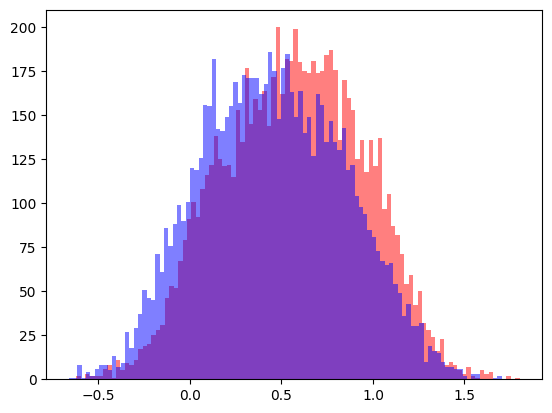

In [36]:
y0, y1 = val_y0, val_y1

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)
pyplot.title('')

## score distribution

In [38]:
model.eval()

with torch.no_grad():
    with torch.cuda.amp.autocast(True):
    
        x = torch.tensor(negative_last_hidden_states_with_mask).permute(0, 2, 1).half()
        # x = torch.tensor(positive_last_hidden_states_with_mask).permute(0, 2, 1).half()

        score = model(x.cuda())
        
    score = score[..., 0].detach().cpu().numpy()

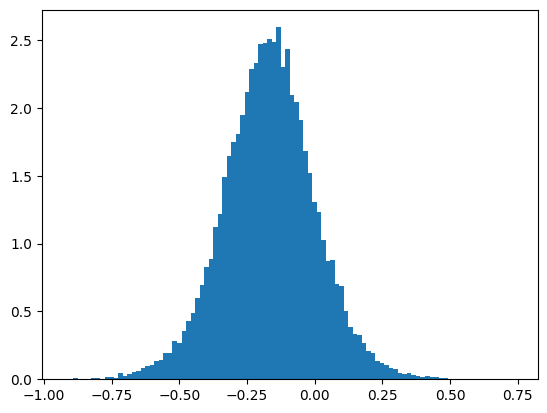

In [39]:
_ = pyplot.hist(score, bins=100, density=True)
pyplot.show()

## prepare for visualization

In [40]:
js = json.load(open(PMT_PATH))
js = {i['file_path']: i for i in js.values()}

In [41]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /openai/clip-vit-large-patch14/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fb4e100caf0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 230a94fd-8505-4cee-8cce-041ffdea1994)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-large-patch14/resolve/main/tokenizer_config.json


In [42]:
def get_details(prompt_sequences: list, embedding_sequences, topk=3):
    
    encoding = tokenizer(
        prompt_sequences,
        truncation=True, max_length=77, return_length=True,
        return_overflowing_tokens=False, padding="max_length", return_tensors="pt"
    )
    
    input_ids = encoding['input_ids']
    
    x = torch.tensor(embedding_sequences).half()
    x = x.view(-1, *x.shape[-2:]).permute(0, 2, 1)

    model.eval()

    with torch.no_grad():

        with torch.cuda.amp.autocast(True):

            attn, scores, score = model(x.cuda(), return_all=True)

            attn = attn.detach().cpu().numpy()
            scores = scores.detach().cpu().numpy()
            score = score.detach().cpu().numpy()
            
    results = list()

    for t_is, t_as, t_ss, s in zip(input_ids, attn, scores, score):

        tokens = tokenizer.convert_ids_to_tokens(t_is)
        
        tags = list()
        last = ([], [], [])
        for token, t_a, t_s in zip(tokens, t_as[0], t_ss[0]):

            token = token.replace('</w>', '')

            last_tokens, last_as, last_ss = last

            if token[0] in ['<', '['] and token[-1] in ['>', ']']:
                if len(last_tokens) > 0:
                    tags.append((' '.join(last_tokens), sum(last_as), sum(i*j for i, j in zip(last_as, last_ss)) / sum(last_as)))
                tags.append((token, t_a, t_s))
                last = ([], [], [])
            else:
                last_tokens.append(token)
                last_as.append(t_a)
                last_ss.append(t_s)

                if ',' in token:
                    tags.append((' '.join(last_tokens), sum(last_as), sum(i*j for i, j in zip(last_as, last_ss)) / sum(last_as)))
                    last = ([], [], [])

        last_tokens, last_as, last_ss = last
        if len(last_tokens) > 0:
            tags.append((' '.join(last_tokens), sum(last_as), sum(i*j for i, j in zip(last_as, last_ss)) / sum(last_as)))
        
        if topk is None:
            results.append(tags) 
            continue
            
        t_texts, t_attns, t_scores = zip(*tags)
        
        topk_ids = np.argsort(t_attns)[::-1][:topk]

        results.append([s[0]] + sum([[t_texts[i], t_attns[i], t_scores[i]] for i in topk_ids], start=[]))     

#         topk_ids = np.argsort(as[0])[::-1][:topk]

#         results.append((s[0],) + sum(zip([tokens[i].replace('</w>', '') for i in topk_ids], as[0, topk_ids], ss[0, topk_ids]), start=()))     
    
    if topk is None:
        return results
        
    results = pd.DataFrame(results, columns=['score'] + sum([[f'{i+1}-token', f'{i+1}-weight', f'{i+1}-score'] for i in range(topk)], start=[]))
    
    return results

In [43]:
def select_samples(indices, n_select):
    
    selected = np.random.choice(indices, n_select, False)
    
    selected_file_paths = [file_paths[i] for i in selected]
    selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]
    
    images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
    images = images.reshape(-1, int(n_select ** 0.5), *images.shape[-3:])
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    
    images = Image.fromarray(images).resize((512, 512))
    
    return selected, images

## show top score samples

In [44]:
threshold = np.quantile(score, q=0.95)
selected, images = select_samples(np.arange(score.shape[0])[score > threshold], n_select=9)

threshold

0.10809775367379176

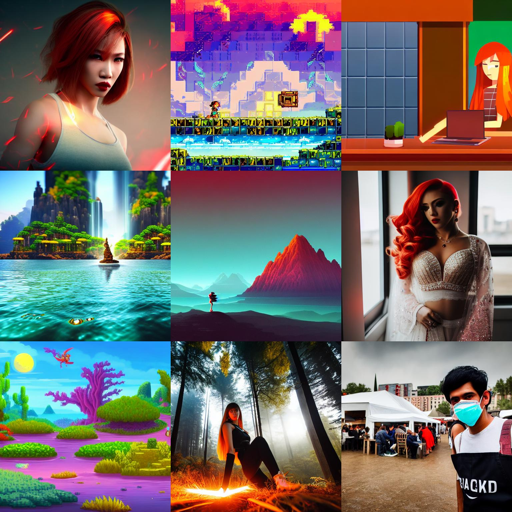

In [45]:
images

In [46]:
get_details(
    
#     [js[i]['positive_prompt'] for i in file_paths[selected]], 
#     positive_last_hidden_states_with_mask[selected]
    
    [js[i]['negative_prompt'] for i in file_paths[selected]], 
    negative_last_hidden_states_with_mask[selected]
    
)

,score,1-token,1-weight,1-score,2-token,2-weight,2-score,3-token,3-weight,3-score
0,0.140690,"sketches ,",0.143728,0.765210,"( white letters : 1 ),",0.129938,0.637460,"bad proportions ,",0.088735,0.043037
1,0.319419,"(( not correct background setting ) ),",0.389344,0.563658,"( bad anatomy : 1 . 2 ) bad body ,",0.207258,0.885876,"ugly ,",0.112875,-0.479262
2,0.407914,"( multiple views : 1 . 4 ),",0.755287,0.539073,"worst quality ,",0.035401,-0.302567,"poorly drawn tent acles ,",0.026838,0.003551
3,0.236433,poorly drawn [ sketch | rough ],0.284149,0.645495,low quality low res the background is in coher...,0.255744,0.161378,"(( bad anatomy ) ),",0.065270,0.327789
4,0.166343,"( fu ta : 1 . 1 ),",0.333246,0.290908,"((( ugly )) ),",0.110019,0.070093,"ng _ deep negative _ v 1 _ 7 5 t ,",0.091551,0.039875
5,0.113496,"bad anatomy ,",0.227944,0.164474,"(( (( nude )) ) ),",0.119107,0.514510,"low quality low res bad face ,",0.109939,-0.305108
6,0.387638,"photo _ realistic _ details ,",0.186878,0.345894,"sketchy lines ,",0.148015,0.520942,"shading background ,",0.117323,0.774283
7,0.259363,"red eyes ,",0.533406,0.536403,"(( dis figured ) ),",0.127143,0.242836,ng _ deep negative _ v 1 _ 7 5 t,0.068657,-0.041051
8,0.147259,"( fu ta : 1 . 1 ),",0.594617,0.261090,"( crown ),",0.063550,0.070301,"bad body ,",0.059391,-0.309180


## show lowest score samples

In [47]:
threshold = np.quantile(score, q=0.05)
selected, images = select_samples(np.arange(score.shape[0])[score < threshold], n_select=9)

threshold

-0.4442110970616341

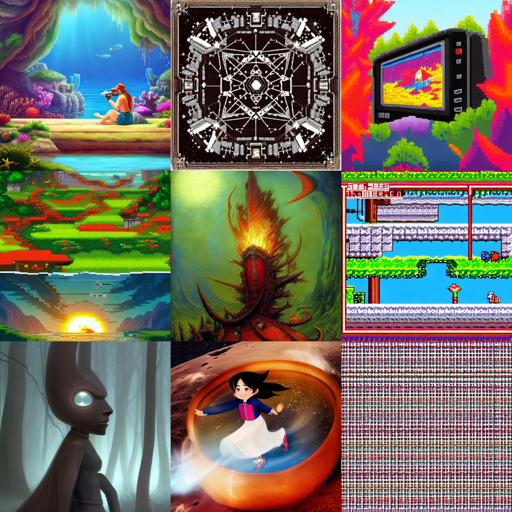

In [48]:
images

In [49]:
get_details(
    
#     [js[i]['positive_prompt'] for i in file_paths[selected]], 
#     positive_last_hidden_states_with_mask[selected]
    
    [js[i]['negative_prompt'] for i in file_paths[selected]], 
    negative_last_hidden_states_with_mask[selected]
)

,score,1-token,1-weight,1-score,2-token,2-weight,2-score,3-token,3-weight,3-score
0,-0.515327,"zombie ,",0.624469,-0.747545,"low res ,",0.097451,-0.728494,"( dis figured : 1 . 3 3 1 ),",0.056608,0.729813
1,-0.462398,"pixel ,",0.313723,-0.746798,"dripping ,",0.293551,-0.433289,"dome ,",0.098489,-0.460506
2,-0.445723,"amu let ,",0.310540,-0.900155,"face out of frame ,",0.137135,-0.201402,"low quality low res long body ,",0.091676,-0.636472
3,-0.461427,"ow res ,",0.346272,-1.070337,"poorly drawn mouth ,",0.117140,-0.282056,"( holding object : 1 . 2 ),",0.106725,0.348838
4,-0.549273,"easy negative ,",0.229847,-0.757025,"robots ,",0.124076,-0.917032,bubble,0.110172,-0.749512
5,-0.635219,zombie,0.591105,-0.988281,"( lo li : 1 . 2 ),",0.098358,0.150889,"ugly ,",0.076475,-0.512831
6,-0.667279,"demons ,",0.554368,-1.117381,"tree trunk ,",0.075852,-0.206807,"journal or marker ,",0.060894,-0.242903
7,-0.456953,"zombie ,",0.593357,-0.787350,"ng _ deep negative _ v 1 _ 7 5 t ,",0.222214,-0.009358,"( missing fingers ),",0.030401,0.393123
8,-0.516454,"zombie ,",0.433798,-0.890561,"ng _ deep negative _ v 1 _ 7 5 t ,",0.123529,0.033897,"low quality low res missing hand ,",0.107881,-0.539501


## show lowest delta samples

In [50]:
n_select = 6

# threshold = np.quantile(val_delta, q=0.05)
# indices = val_pairs.index[np.arange(val_delta.shape[0])[val_delta < threshold]]
# selected = np.random.choice(indices, n_select, False)

selected = val_pairs.index[np.argsort(val_delta)[:n_select]]

indices_1 = [path_to_index[i] for i in val_pairs.loc[selected, 'image_1']]
indices_2 = [path_to_index[i] for i in val_pairs.loc[selected, 'image_2']]

In [51]:
selected_file_paths = [file_paths[i] for i in indices_1]
selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
images_1 = np.concatenate(images, axis=-2)

selected_file_paths = [file_paths[i] for i in indices_2]
selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]

images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
images_2 = np.concatenate(images, axis=-2)

images = np.concatenate([images_1, images_2], axis=-3)

images = Image.fromarray(images).resize((512 * n_select // 2, 512))

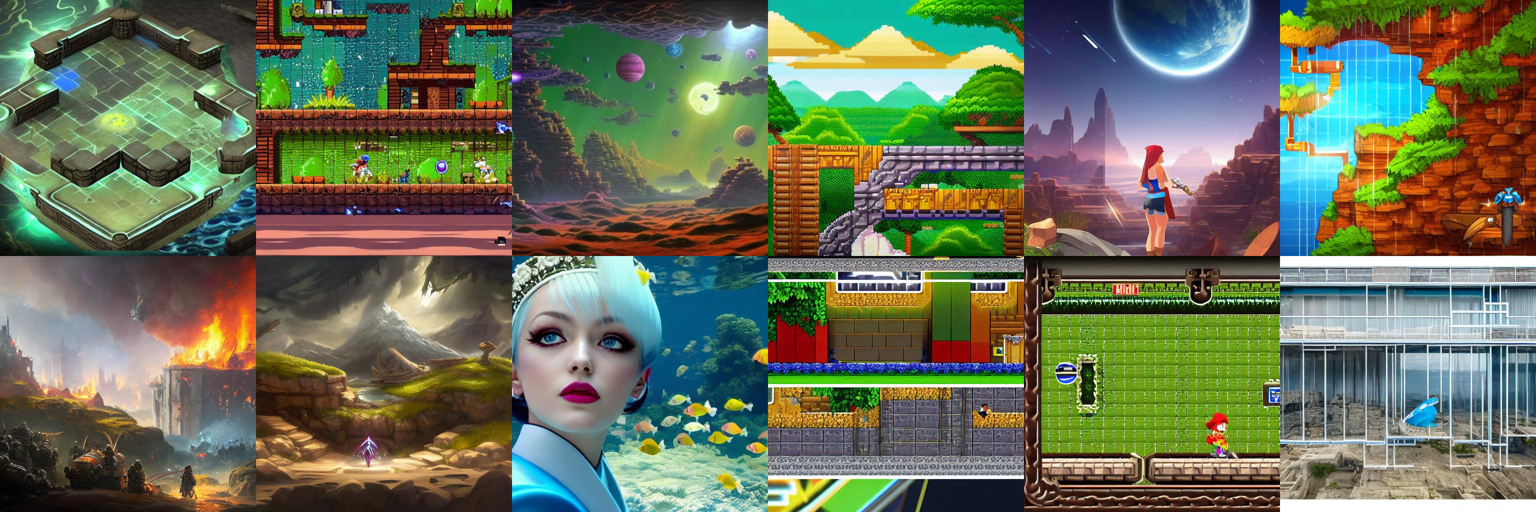

In [52]:
images

In [53]:
get_details(
    # [js[i]['positive_prompt'] for i in file_paths[indices_1]], 
    # positive_last_hidden_states_with_mask[indices_1]
    
    [js[i]['negative_prompt'] for i in file_paths[indices_1]], 
    negative_last_hidden_states_with_mask[indices_1]
)

,score,1-token,1-weight,1-score,2-token,2-weight,2-score,3-token,3-weight,3-score
0,-0.476604,"background 0 5 3 0 8 6 ,",0.274612,-0.588612,"glasses cloak ,",0.203516,-0.758511,"beard ,",0.176254,-0.490278
1,-0.880348,"worst quality ,",0.700047,-1.123639,"low quality low res bad camel toe ,",0.105568,-0.591038,"bu sty ,",0.064024,-0.248521
2,-0.460078,"city ,",0.898405,-0.472476,"text 0 5 2 3 ,",0.026913,-0.427873,"beard ,",0.021535,-0.544100
3,-0.667366,"zombie ,",0.509782,-0.947697,"low quality low res 2 k oma ,",0.156771,-0.555597,"video game ,",0.090094,-0.328692
4,-0.534781,"zombie ,",0.409524,-0.713558,"bad dream ,",0.231464,-0.596058,"bad - hands - 5 ,",0.057396,-0.412314
5,-0.257444,"video game ,",0.560414,-0.367812,"lr ,",0.129927,0.026563,"bad _ prompt _ version 2 : 0 . 8 ,",0.096770,-0.165183


In [54]:
get_details(
    # [js[i]['positive_prompt'] for i in file_paths[indices_2]], 
    # positive_last_hidden_states_with_mask[indices_2]
    
    [js[i]['negative_prompt'] for i in file_paths[indices_2]], 
    negative_last_hidden_states_with_mask[indices_2]
)

,score,1-token,1-weight,1-score,2-token,2-weight,2-score,3-token,3-weight,3-score
0,-0.039345,"tattoo ,",0.108495,0.300431,"((( six fingers )) ),",0.097318,-0.136039,"cross - eyed ,",0.093961,-0.127350
1,-0.232259,"( low resolution : 1 . 3 ),",0.277018,-0.194828,"( worst quality : 1 . 4 ),",0.166583,-0.312923,tre mbling,0.116210,-0.559495
2,0.197195,"(( bad anatomy ) ),",0.280768,0.829818,"dis figured ,",0.097724,-0.266030,"low quality low res cracked mouth ,",0.089428,-0.251284
3,0.023336,"painting by bad - artist ,",0.208934,-0.025278,"is in the nude with no bra or panties ,",0.160433,0.165742,"((( extra legs )) ),",0.123062,0.675167
4,-0.050255,"(( bad anatomy ) ),",0.301577,0.429703,"( worst quality : 1 . 4 ),",0.103390,-0.209509,"blurry _ foreground ,",0.087822,-0.685691
5,0.169965,"( bad - artist - anime : 0 . 8 ),",0.293011,-0.207902,"( bad hands : 1 . 2 ),",0.150030,0.863679,"patreon logo ,",0.146893,0.282410


In [55]:
results = list()

for i in tqdm(range(0, file_paths.shape[0], 64)):
    
    results.extend(get_details(
        
        # [js[j]['positive_prompt'] for j in file_paths[i:i+64]], 
        # positive_last_hidden_states_with_mask[i:i+64],
        
        [js[j]['negative_prompt'] for j in file_paths[i:i+64]], 
        negative_last_hidden_states_with_mask[i:i+64],
        
        topk=None
    ))

  0%|          | 0/483 [00:00<?, ?it/s]

In [56]:
dicts = dict()
for result in results:
    for tag, t_a, t_s in result:
        if tag not in dicts:
            dicts[tag] = {'weight': [], 'score': []}
        dicts[tag]['weight'].append(float(t_a))
        dicts[tag]['score'].append(float(t_s))      

In [57]:
# json.dump(dicts, open('data/positive_scores.json', 'w'))
json.dump(dicts, open('data/negative_scores.json', 'w'))

In [58]:
tags, tag_freqs, tag_weights, tag_scores = list(), list(), list(), list()
for tag, info in dicts.items():
    tags.append(tag)
    tag_freqs.append(len(info['weight']))
    tag_weights.append(np.mean(info['weight']))
    tag_scores.append(np.mean(info['score']))
    
tag_info = pd.DataFrame(zip(tag_freqs, tag_weights, tag_scores), index=tags, columns=['freq', 'weight', 'score'])

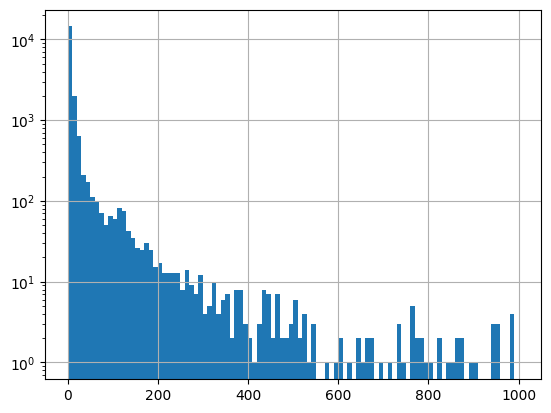

In [65]:
_ = tag_info['freq'].hist(bins=100, log=True, range=(0, 1000))

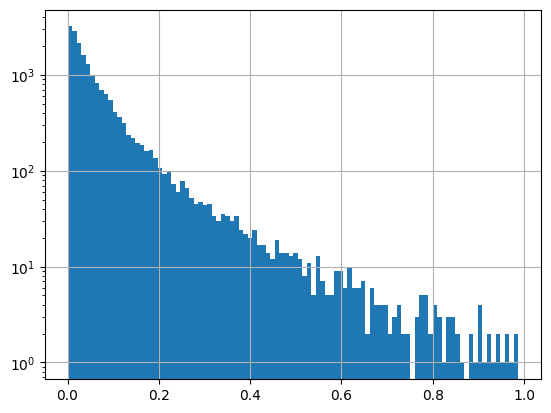

In [69]:
_ = tag_info['weight'].hist(bins=100, log=True)

## highest freq

In [59]:
tag_info.sort_values(by='freq').tail(10)

,freq,weight,score
"fewer digits ,",6659,0.009522,0.006008
"bad anatomy ,",6661,0.090615,0.267929
"worst quality ,",7027,0.090381,-0.346902
"extra fingers ,",7065,0.006857,-0.156910
"bad hands ,",7214,0.016620,-0.010499
"ugly ,",7526,0.132844,-0.389963
"low res ,",7912,0.054692,-0.491796
"normal quality ,",8211,0.019424,-0.397201
<|startoftext|>,30892,0.007636,0.000000
<|endoftext|>,322774,0.007630,0.000000


## highest weight

In [66]:
tag_info.query('freq > 100').sort_values(by='weight').tail(10)

,freq,weight,score
"( fu ta : 1 . 1 ),",431,0.300724,0.065674
anime,153,0.340525,-0.291503
"bo keh ,",661,0.350586,-0.235949
"anime ,",2199,0.373928,-0.220481
"zombie ,",985,0.396345,-0.817769
"bad - artist - anime ,",766,0.407567,-0.121342
"try po phobia ,",353,0.475082,-0.539406
"( bad - artist - anime : 0 . 8 ),",118,0.479993,-0.104946
"low quality low res zombie ,",107,0.504330,-0.818981
"castle ,",198,0.770849,-0.296387


## highest score

In [72]:
tag_info.query('freq > 100 and weight > 0.05').sort_values(by='score').tail(20)

,freq,weight,score
(( poorly drawn face )),152,0.071998,0.185553
"missing ears ,",293,0.072471,0.188594
"plain background ,",111,0.061235,0.195622
"bad leg anatomy ,",126,0.053057,0.216885
"( extra digit and hands and fingers and legs and arms : 1 . 4 ),",696,0.060027,0.229103
"simple background ,",942,0.141482,0.230057
"( long hair : 1 . 4 ),",222,0.065546,0.245589
"bad anatomy ,",6661,0.090615,0.267929
"( simple background ),",212,0.142632,0.300572
"(( water mark : 2 ) ),",261,0.054440,0.307467


## lowest score

In [68]:
tag_info.query('freq > 100 and weight > 0.1').sort_values(by='score').head(10)

,freq,weight,score
"low quality low res zombie ,",107,0.504330,-0.818981
"zombie ,",985,0.396345,-0.817769
"metal ,",248,0.180095,-0.674115
"grey scale ,",1165,0.129947,-0.643359
"robots ,",243,0.129897,-0.630428
"tre mbling ,",389,0.129299,-0.589953
"glasses cloak ,",128,0.171665,-0.580519
"pixel ,",1005,0.145696,-0.573975
"pixel art ,",240,0.178504,-0.558194
"try po phobia ,",353,0.475082,-0.539406
